In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import *
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
import umap.umap_ as umap

random_state = 1000

In [2]:
df = pd.read_csv('../data/rock_data.csv')
df.columns

Index(['Sample ID', 'Rock ID', 'Class', 'Orientation', 'Perimeter', 'Area',
       'Axis Major Length', 'Axis Minor Length', 'Mean Height',
       'Median Height', 'Max Height', 'STD Height', 'Mean Gradient',
       'STD Gradient', 'Gradient at Max', 'Weighted Hu Moment 1',
       'Weighted Hu Moment 2', 'Weighted Hu Moment 3', 'Weighted Hu Moment 4'],
      dtype='object')

In [3]:
# handle missing values
if df.isnull().values.any():
    df.fillna(df.mean(), inplace=True)
    print('Missing values filled with mean.')

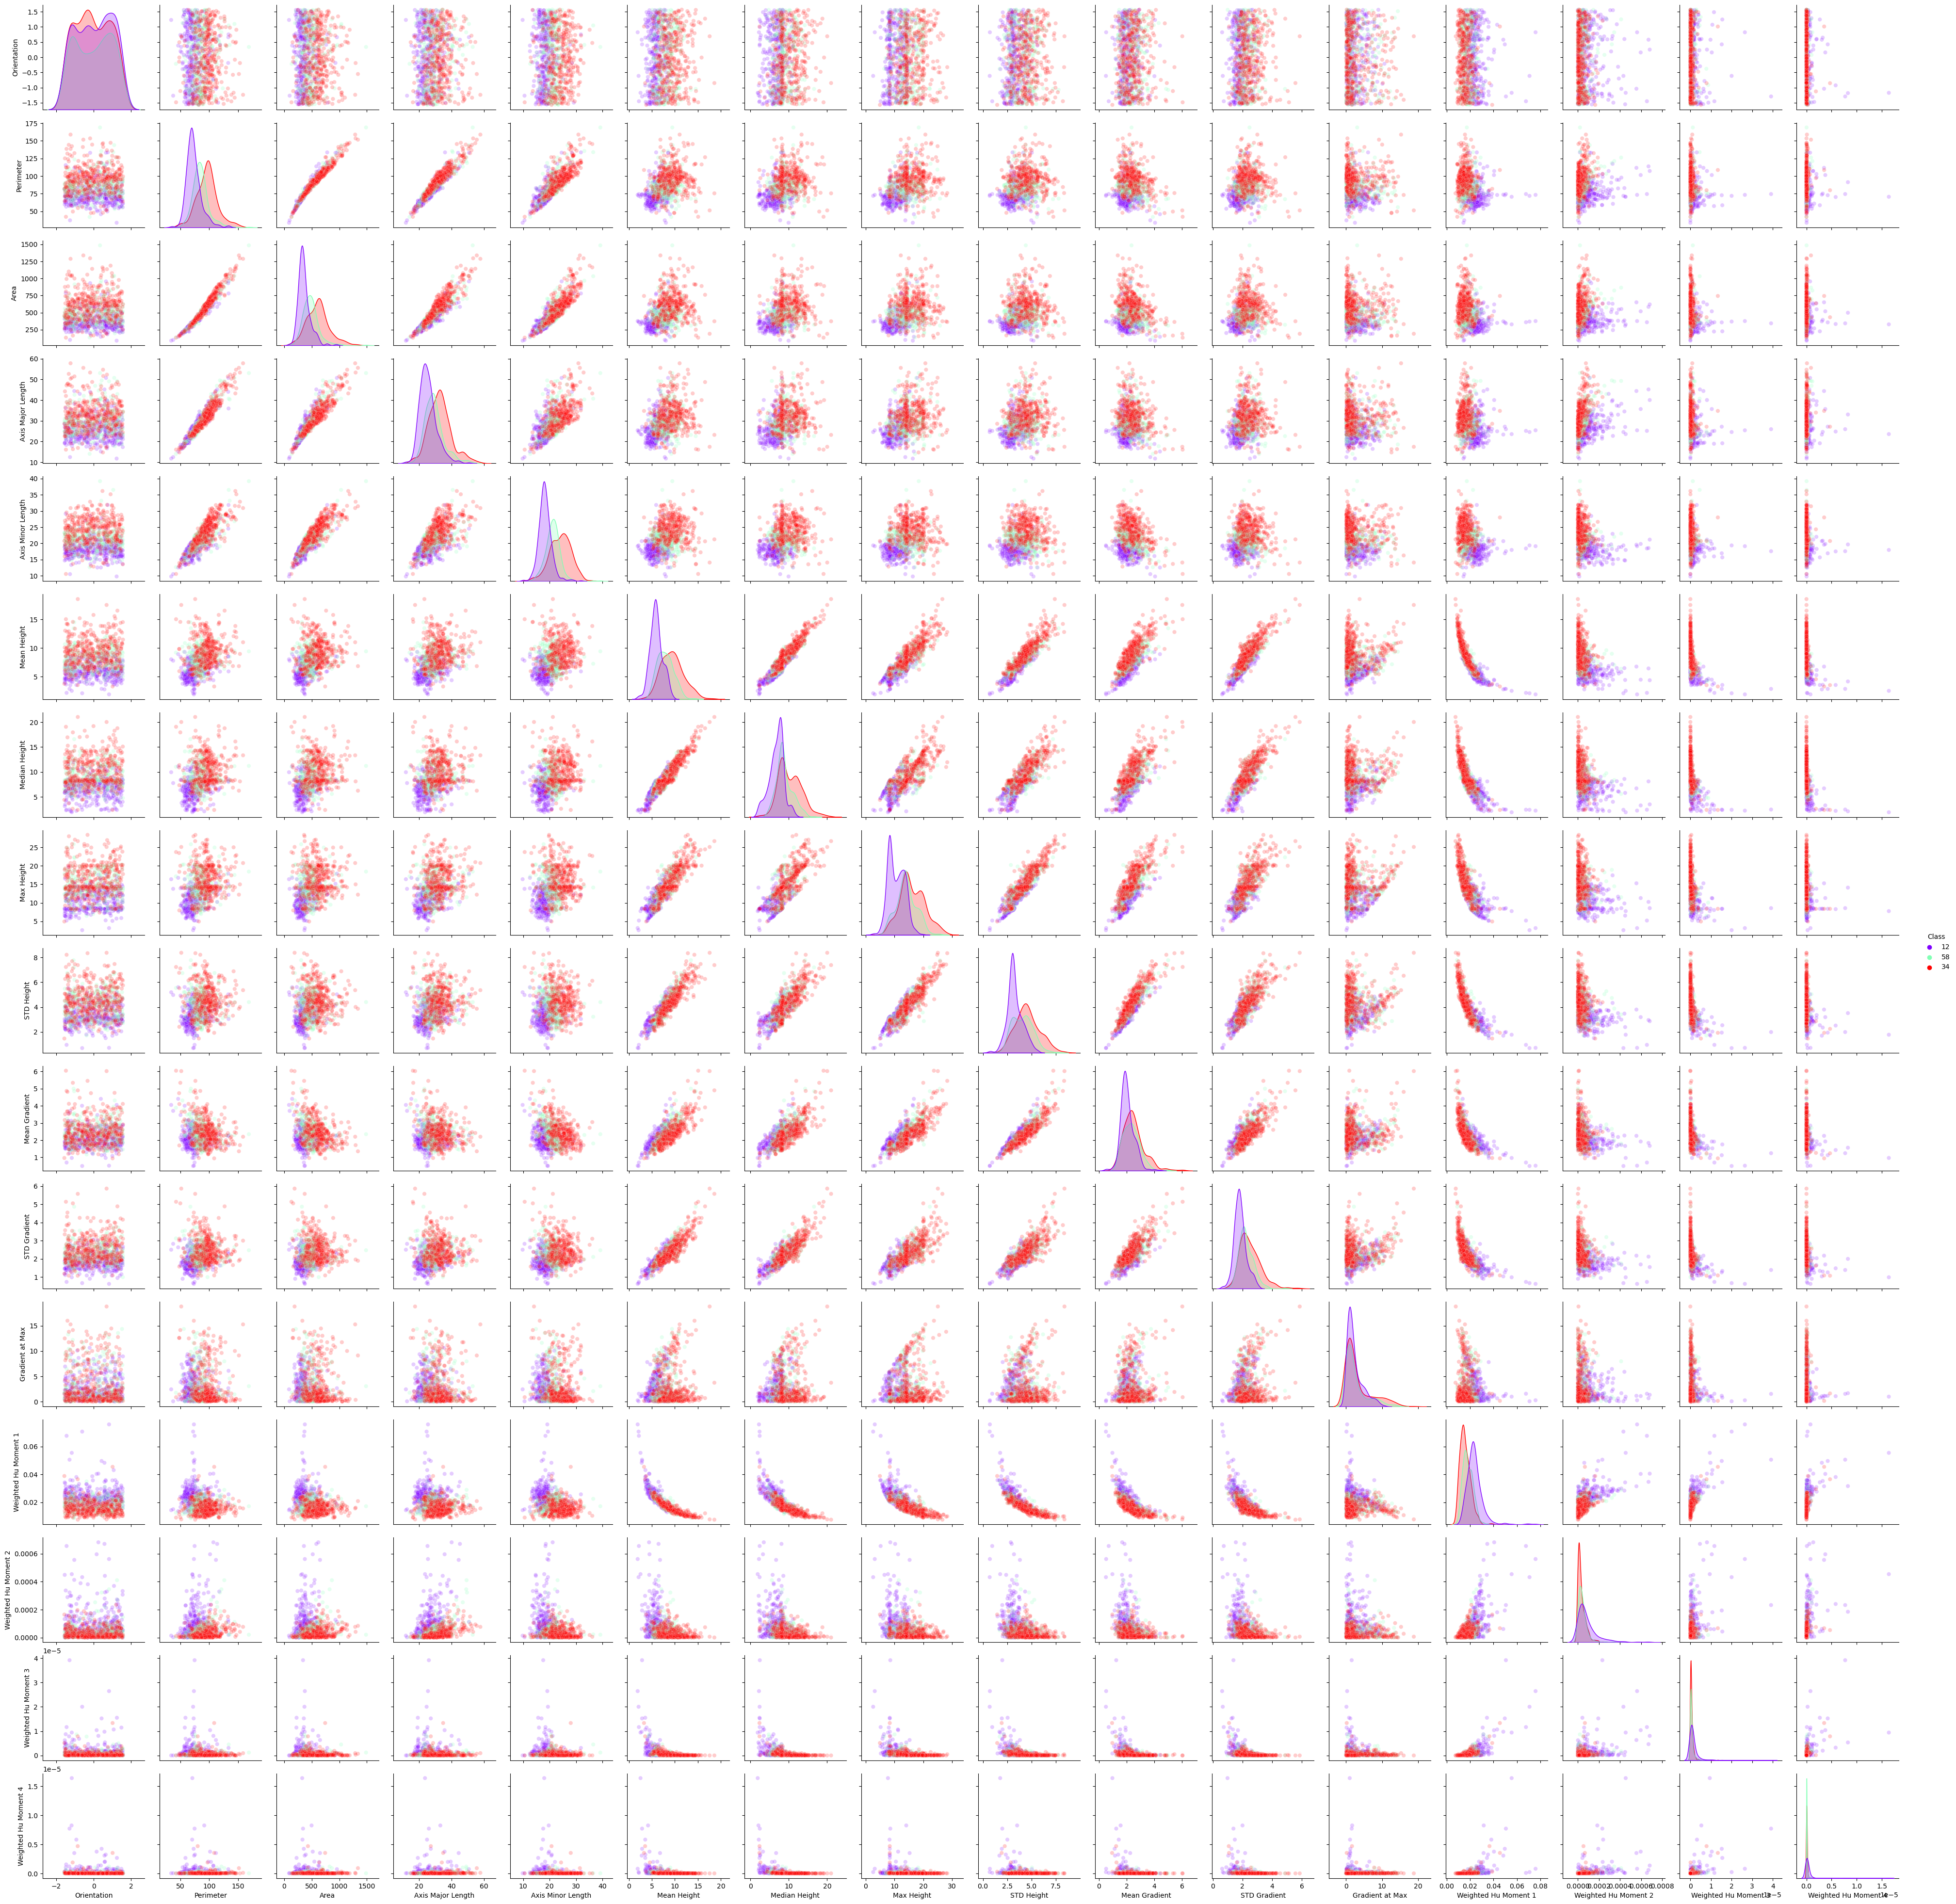

In [4]:
n_clusters = 3
c_map = cm.rainbow(np.linspace(0, 1, n_clusters))
sns.pairplot(df.iloc[:,2:], hue='Class', hue_order=[12, 58, 34], palette={12: c_map[0], 58: c_map[1], 34: c_map[2]}, plot_kws={'alpha':0.2})

In [5]:
# drop highly correlated features
df.drop(['Area', 'Perimeter','Median Height', 'Max Height', 'STD Height'], axis=1, inplace=True)
df.columns

Index(['Sample ID', 'Rock ID', 'Class', 'Orientation', 'Axis Major Length',
       'Axis Minor Length', 'Mean Height', 'Mean Gradient', 'STD Gradient',
       'Gradient at Max', 'Weighted Hu Moment 1', 'Weighted Hu Moment 2',
       'Weighted Hu Moment 3', 'Weighted Hu Moment 4'],
      dtype='object')

In [6]:
# normalize features
df.iloc[:,3:] = df.iloc[:,3:].apply(zscore)

In [7]:
# detect and remove outliers

For ground-truth clustering, the average silhouette_score = 0.016542418009077783


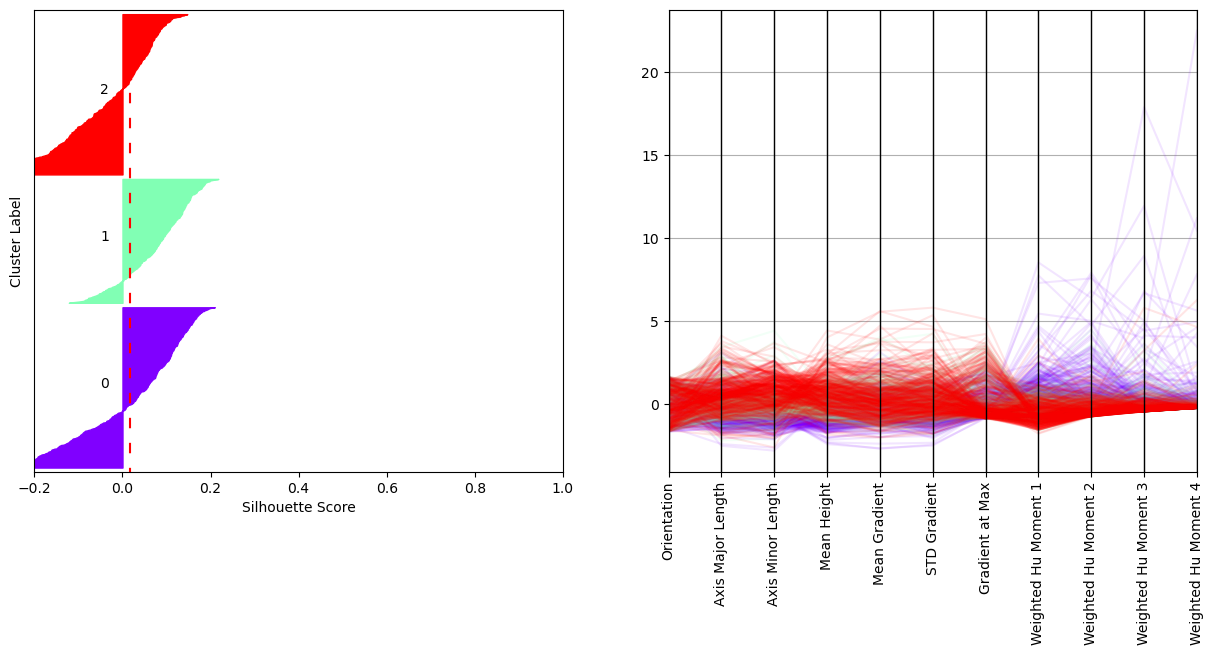

In [8]:
n_clusters = 3
X = df.iloc[:,3:].to_numpy(dtype=float)
df_clustered = df.iloc[:,3:].copy()

def map_class_values(x):
    mapping = {12: 0, 58: 1, 34: 2}
    return mapping.get(x,None)

actual_class = np.vectorize(map_class_values)(df['Class'].values)
df_clustered['cluster'] = actual_class
kmeans_sil = silhouette_score(X, actual_class)
samps_sil = silhouette_samples(X, actual_class)

print(f"For ground-truth clustering, the average silhouette_score = {kmeans_sil}")

fig, axs = subplots(nrows=1, ncols=2, figsize=(15,6))

c_map = cm.rainbow(np.linspace(0, 1, n_clusters))

y_lower = 10
for i in range(n_clusters):
    cluster_sil = np.sort(samps_sil[actual_class == i])
    y_upper = y_lower + cluster_sil.shape[0]

    axs[0].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil, color=c_map[i])

    axs[0].set_xlim([-0.2, 1])
    axs[0].set_ylim([0, len(X) + (n_clusters + 1) * 10])
    axs[0].text(-0.05, y_lower + 0.5 * cluster_sil.shape[0], str(i))

    y_lower = y_upper + 10

axs[0].set_xlabel("Silhouette Score")
axs[0].set_ylabel("Cluster Label")

axs[0].axvline(x=kmeans_sil, color="red", linestyle=(3,(5,7)))

axs[0].set_yticks([])
axs[0].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

pd.plotting.parallel_coordinates(df_clustered, 'cluster', ax=axs[1], color=c_map, alpha=0.1)
xticks(rotation=90)
axs[1].legend().set_visible(False)

show()

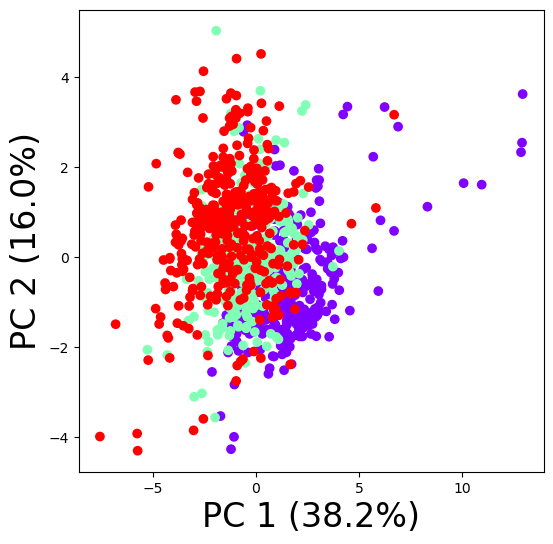

In [9]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig, axs = subplots(nrows=1, ncols=1, figsize=(6,6))

c_map = cm.rainbow(np.linspace(0, 1, n_clusters))
axs.scatter(components[:,0], components[:,1], color=df_clustered['cluster'].map(lambda x: c_map[x]))
axs.set_xlabel(labels['0'], fontsize=24)
axs.set_ylabel(labels['1'], fontsize=24)

show()

In [10]:
sort_idx = np.argsort(-np.abs(pca.components_[0]))
for si in sort_idx:
    print(f'{df.columns[3+si]}: {pca.components_[0][si]}')

Weighted Hu Moment 1: 0.4653678209609606
Mean Height: -0.44823511494017565
STD Gradient: -0.41533805857649786
Mean Gradient: -0.38050420411403063
Weighted Hu Moment 3: 0.3073843387309015
Weighted Hu Moment 2: 0.2660009132444221
Weighted Hu Moment 4: 0.22356510554670184
Axis Minor Length: -0.15595923414567275
Axis Major Length: -0.12040195048589283
Gradient at Max: -0.10298033737014278
Orientation: -0.024105693416297678


In [11]:
sort_idx = np.argsort(-np.abs(pca.components_[1]))
for si in sort_idx:
    print(f'{df.columns[3+si]}: {pca.components_[1][si]}')

Axis Major Length: 0.6833878657927398
Axis Minor Length: 0.6205296183788974
Mean Gradient: -0.2492043294358081
Weighted Hu Moment 2: 0.20077015307709403
Weighted Hu Moment 4: 0.12880491385316736
Mean Height: 0.1218225919209235
Gradient at Max: -0.0819785289419294
Weighted Hu Moment 3: 0.07220258958419319
STD Gradient: -0.035995256434754874
Weighted Hu Moment 1: 0.02456674839237622
Orientation: 0.015755599895133105


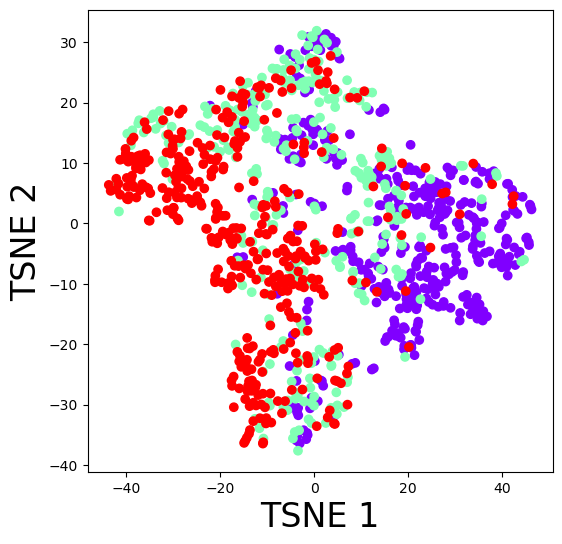

In [12]:
tsne = TSNE(n_components=2)
embedding = tsne.fit_transform(X)
labels = {
    str(i): f"TSNE {i+1}" for i in range(2)
}

fig, axs = subplots(nrows=1, ncols=1, figsize=(6,6))

c_map = cm.rainbow(np.linspace(0, 1, n_clusters))
axs.scatter(embedding[:,0], embedding[:,1], color=df_clustered['cluster'].map(lambda x: c_map[x]))
axs.set_xlabel(labels['0'], fontsize=24)
axs.set_ylabel(labels['1'], fontsize=24)

show()

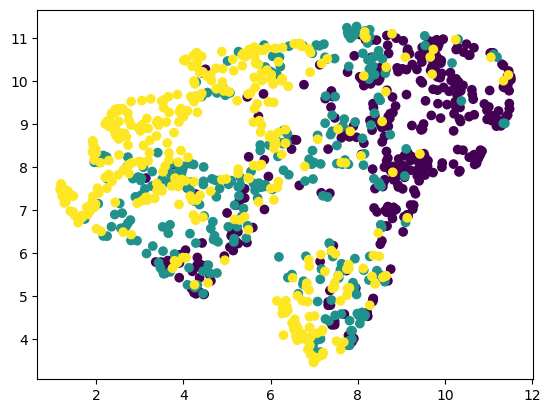

In [13]:
um = umap.UMAP()
embedding = um.fit_transform(X)
scatter(embedding[:, 0], embedding[:, 1], c=df_clustered['cluster'])